<a href="https://colab.research.google.com/github/tchintchie/Popular_Data_Science_Questions/blob/master/Popular_Data_Science_Questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Popular Data Science Questions

In this scenario, you're working for a company that creates data science content, be it books, online articles, videos or interactive text-based platforms like Dataquest.

You're tasked with figuring out what is best content to write about. Because you took this course, you know that given the lack of instructions there's some leeway in what "best" means here.

Since you're passionate about helping people learn, you decide to scower the internet in search for the answer to the question "What is it that people want to learn about in data science?" (as opposed to determining the most profitable content, for instance).

Thinking back to your experience when you first started learning programming, it occurs to you that if you wanted to figure out what programming content to write, you could consult Stack Overflow (a question and answer website about programming) and see what kind of content is more popular.

The fact that DSSE https://stackexchange.com/sites?view=list#percentanswered https://datascience.stackexchange.com is a data science dedicated site (contrarily to the others), coupled with it having a lot of an unanswered questions, makes it an ideal candidate for this investigation. DSSE will be the focus of this guided project.

---

- What kind of questions are welcome on this site?
 - ML, Python, Neural Networks, Deep Learning ...
- What, other than questions, does the site's home subdivide into?
 - Tags, Users and Unanswered
 - Does any of them look useful towards our goal?
  - Most likely Tags
- What information is available in each post?
 - Votes, Timestamp, User, Tags, Answers
- Explore some of the questions that were asked.
- Try asking a couple of questions on any of Stack Exchange sites to get a better feel for how the sites operate.

---

- Explore Data Science Stack Exchange's data model.
 - Investigate a few of the tables, especially those whose names sound more promising;
 - Write a few queries to get a feel for the data;
 ```
 select top 10 Id, Title, Score, ViewCount, AnswerCount from Posts
order by AnswerCount desc;
 ```
- In a markdown cell, write about what tables look more promising towards finding the most popular content.
 - Posts, Tags, eventually Badges

## Getting the Data
https://data.stackexchange.com/datascience/query/new

```
SELECT PostTypeId, COUNT(*) as NrOfPosts
  FROM posts
  WHERE CreationDate BETWEEN '2019-01-01' AND '2019-12-31'
 GROUP BY PostTypeId;
```

|PostTypeId|NrOfPosts|
|---|---|
|1|8642|
|2|7768|
|4|91|
|5|91|
|6|8|

### Run a query against the SEDE DSSE database that extracts the columns listed above for all the questions in 2019
```
SELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
  FROM posts
  WHERE CreationDate BETWEEN '2019-01-01' AND '2019-12-31'
```

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
import seaborn as sns
import re
from itertools import islice

In [0]:
df = pd.read_csv("2019_questions.csv")

- Explore the data. Try to answer a few of these questions in a markdown cell:
 - How many missing values are there in each column?
 - Can we fix the missing values somehow?
 - Are the types of each column adequate?
 - What can we do about the Tags column?

In [126]:
# How many missing values are there in each column?
df.isnull().sum()

Id                   0
PostTypeId           0
CreationDate         0
Score                0
ViewCount         7958
Tags              7958
AnswerCount       7958
FavoriteCount    15152
dtype: int64

In [0]:
# Can we fix the missing values somehow?
df.ViewCount.fillna(0, inplace=True)

In [0]:
df.AnswerCount.fillna(0, inplace=True)
df.FavoriteCount.fillna(0,inplace=True)

In [129]:
df.Tags.value_counts()

<machine-learning>                                                            114
<python><pandas>                                                               58
<python>                                                                       53
<r>                                                                            38
<tensorflow>                                                                   36
                                                                             ... 
<neural-network><data-science-model>                                            1
<nlp><natural-language-process><information-retrieval><question-answering>      1
<nlp><sentiment-analysis><lda><dirichlet>                                       1
<neural-network><deep-learning><tensorflow><lstm>                               1
<machine-learning><python><time-series><jupyter><anaconda>                      1
Name: Tags, Length: 6341, dtype: int64

In [0]:
df.Tags = df.Tags.str.replace("^<|>$", "").str.split("><")

In [0]:
df.Tags.fillna("None", inplace=True)

In [132]:
df.Tags.values

array(['None', 'None', 'None', ...,
       list(['bigdata', 'apache-spark', 'dataframe', 'scala']),
       list(['machine-learning']), list(['classification', 'churn'])],
      dtype=object)

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16600 entries, 0 to 16599
Data columns (total 8 columns):
Id               16600 non-null int64
PostTypeId       16600 non-null int64
CreationDate     16600 non-null object
Score            16600 non-null int64
ViewCount        16600 non-null float64
Tags             16600 non-null object
AnswerCount      16600 non-null float64
FavoriteCount    16600 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.0+ MB


In [0]:
df.CreationDate = pd.to_datetime(df.CreationDate)
df.ViewCount = df.ViewCount.astype(int)
df.AnswerCount = df.AnswerCount.astype(int)
df.FavoriteCount = df.FavoriteCount.astype(int)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16600 entries, 0 to 16599
Data columns (total 8 columns):
Id               16600 non-null int64
PostTypeId       16600 non-null int64
CreationDate     16600 non-null datetime64[ns]
Score            16600 non-null int64
ViewCount        16600 non-null int64
Tags             16600 non-null object
AnswerCount      16600 non-null int64
FavoriteCount    16600 non-null int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 1.0+ MB


In [136]:
df.Tags.head()

0                                     None
1                                     None
2                                     None
3                                     None
4    [machine-learning, image-recognition]
Name: Tags, dtype: object

In [0]:
corr = df.corr()

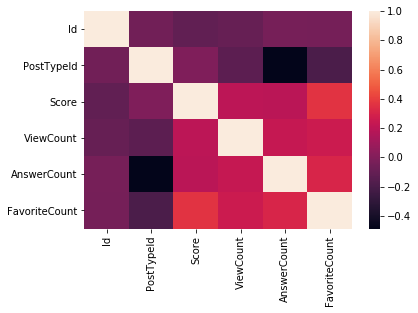

In [138]:
sns.heatmap(corr)
plt.show()

We now focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

We could take into account the score, or whether or not a question is part of someone's favorite questions. These are all reasonable options to investigate; but we'll limit the focus of our research to counts and views for now.

## Count how many times each tag was used.

In [139]:
df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,52361,2,2019-05-22 02:15:55,1,0,None,0,0
1,52362,2,2019-05-22 02:29:42,0,0,None,0,0
2,52364,2,2019-05-22 03:17:51,1,0,None,0,0
3,52365,2,2019-05-22 03:21:25,1,0,None,0,0
4,52366,1,2019-05-22 03:24:53,0,6,"[machine-learning, image-recognition]",0,0


In [140]:
tag_count = {}
for row in df.Tags.loc[df.Tags.notnull()]:
    for lists in row:
        if lists in tag_count:
            tag_count[lists] += 1
        else:
            tag_count[lists] = 1
        

del tag_count["N"]
del tag_count["o"]
del tag_count["n"]
del tag_count["e"]

tag_count

{'.net': 1,
 '3d-object-detection': 1,
 '3d-reconstruction': 9,
 'ab-test': 6,
 'accuracy': 89,
 'activation': 1,
 'activation-function': 44,
 'active-learning': 4,
 'activity-recognition': 5,
 'actor-critic': 21,
 'adaboost': 1,
 'aggregation': 11,
 'ai': 25,
 'alex-net': 5,
 'algorithms': 65,
 'allennlp': 2,
 'anaconda': 20,
 'ann': 2,
 'annotation': 12,
 'anomaly': 4,
 'anomaly-detection': 89,
 'anonymization': 3,
 'anova': 1,
 'apache-hadoop': 12,
 'apache-nifi': 1,
 'apache-spark': 33,
 'arima': 11,
 'association-rules': 17,
 'attention-mechanism': 26,
 'auc': 3,
 'audio-recognition': 25,
 'autoencoder': 102,
 'automatic-summarization': 10,
 'automation': 4,
 'automl': 2,
 'aws': 20,
 'aws-lambda': 2,
 'azure-ml': 12,
 'backpropagation': 65,
 'batch-normalization': 28,
 'bayes-error': 1,
 'bayesian': 37,
 'bayesian-networks': 11,
 'bayesian-nonparametric': 2,
 'beginner': 27,
 'bert': 63,
 'bias': 19,
 'bigdata': 91,
 'binary': 26,
 'bioinformatics': 4,
 'books': 7,
 'boosting': 4

In [141]:
most_used = pd.DataFrame.from_dict(tag_count, orient="index")
most_used.rename(columns={0: "Count"}, inplace=True)
most_used.sort_values(by="Count", inplace=True, ascending=False)
most_used.head(10)

,Count
machine-learning,2642
python,1785
deep-learning,1190
neural-network,1038
keras,919
classification,669
tensorflow,573
scikit-learn,530
cnn,484
nlp,484


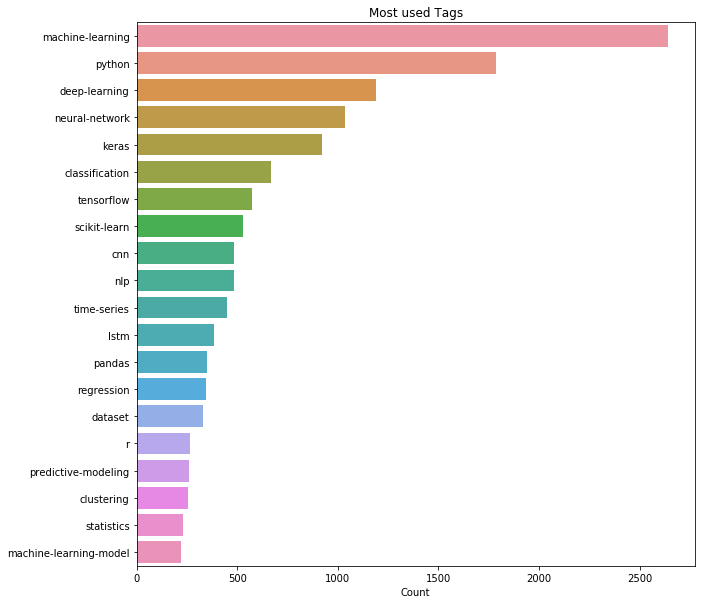

In [142]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return dict(islice(iterable, n))

#top_used = take(20, tag_count.items())
#top_used_keys = top_used.keys()
#top_used_values = top_used.values()

#list(top_used_keys)
#list(top_used_values)


#top_used = pd.DataFrame(top_used_values, top_used_keys)
#top_used.sort_values(by=[0],inplace=True, ascending=False)
top_used = most_used.head(20)

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(x=top_used.Count, y=top_used.index)
plt.title("Most used Tags")
plt.show()

## Count how many times each tag was viewed.

In [143]:
df.sort_values(by="ViewCount", ascending=False)[["Tags", "ViewCount"]].head(20)

,Tags,ViewCount
12628,"[python, pandas]",47596
7353,"[python, dataframe, csv, data-formats]",36912
14206,"[machine-learning, neural-network, deep-learni...",34882
14051,"[data-mining, pandas]",21734
7787,"[scikit-learn, pandas, numpy]",16346
2437,"[pandas, dataframe, excel, data.table]",14301
11307,"[python, computer-vision, opencv]",14202
1598,"[machine-learning, python]",13026
13709,"[nlp, encoding, attention-mechanism, transformer]",10623
7342,"[python, matplotlib, seaborn]",10290


In [0]:
tag_views = {}

for idx, tags in enumerate(df.Tags):
    for tag in tags:
        if tag in tag_views:
            tag_views[tag] += df.ViewCount.iloc[idx]
        else:
            tag_views[tag] = 1

In [145]:
del tag_views["N"]
del tag_views["o"]
del tag_views["n"]
del tag_views["e"]

tag_views

{'.net': 1,
 '3d-object-detection': 1,
 '3d-reconstruction': 198,
 'ab-test': 142,
 'accuracy': 19070,
 'activation': 1,
 'activation-function': 17223,
 'active-learning': 161,
 'activity-recognition': 85,
 'actor-critic': 1438,
 'adaboost': 1,
 'aggregation': 954,
 'ai': 4166,
 'alex-net': 194,
 'algorithms': 5742,
 'allennlp': 213,
 'anaconda': 14097,
 'ann': 65,
 'annotation': 1166,
 'anomaly': 155,
 'anomaly-detection': 13548,
 'anonymization': 538,
 'anova': 1,
 'apache-hadoop': 523,
 'apache-nifi': 1,
 'apache-spark': 6446,
 'arima': 1739,
 'association-rules': 691,
 'attention-mechanism': 19984,
 'auc': 75,
 'audio-recognition': 2736,
 'autoencoder': 19118,
 'automatic-summarization': 694,
 'automation': 129,
 'automl': 89,
 'aws': 2466,
 'aws-lambda': 36,
 'azure-ml': 709,
 'backpropagation': 13383,
 'batch-normalization': 6091,
 'bayes-error': 1,
 'bayesian': 3533,
 'bayesian-networks': 921,
 'bayesian-nonparametric': 25,
 'beginner': 2632,
 'bert': 38505,
 'bias': 1592,
 'big

In [146]:
most_viewed = pd.DataFrame.from_dict(tag_views, orient="index")
most_viewed.rename(columns={0: "Views"}, inplace=True)
most_viewed.sort_values(by="Views",ascending=False, inplace=True)
most_viewed.head(10)

,Views
python,707844
machine-learning,487527
keras,338979
deep-learning,290611
pandas,285411
neural-network,233860
scikit-learn,165347
tensorflow,157698
classification,129535
dataframe,118976


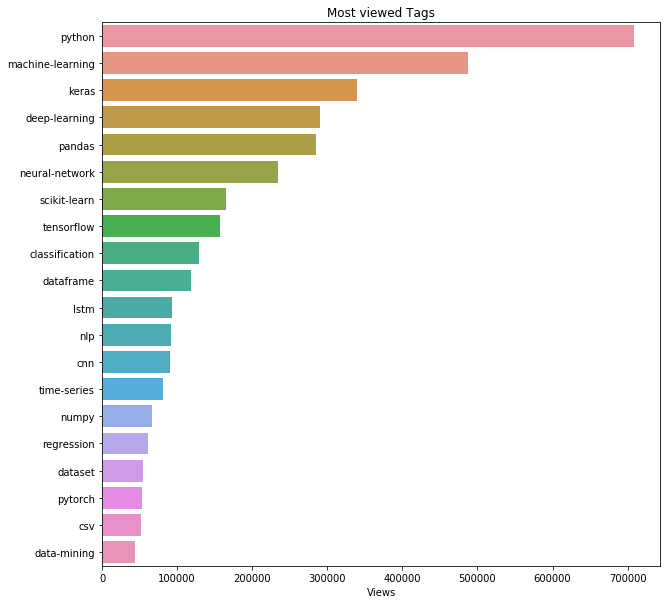

In [147]:
top_viewed = most_viewed.head(20)

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(x=top_viewed.Views, y=top_viewed.index)
plt.title("Most viewed Tags")
plt.show()

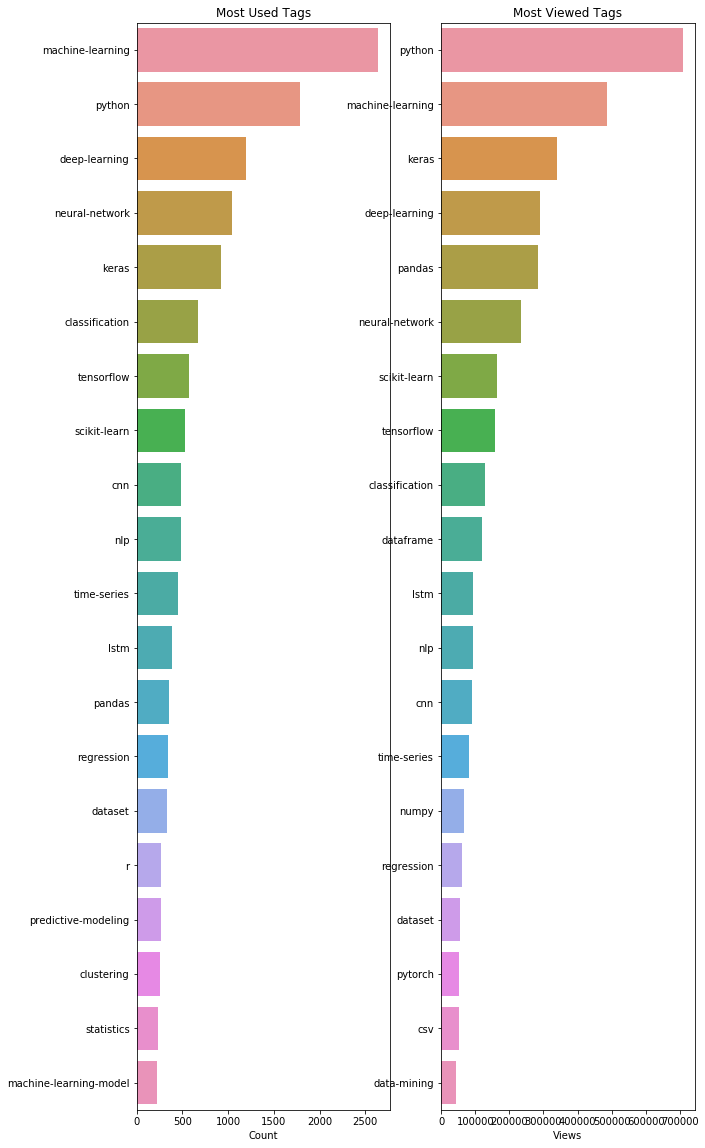

In [148]:
# compare both plots 
fig, ax = plt.subplots(1,2, figsize = (10,20))
sns.barplot(x=top_used.Count, y=top_used.index, ax=ax[0]).set_title("Most Used Tags")
sns.barplot(x=top_viewed.Views, y=top_viewed.index, ax=ax[1]).set_title("Most Viewed Tags")

plt.show()

# Relation between Tags
Let's see what tags are in most_used, but not in most_viewed. We can identify them by the missing values in ViewCount below.

In [149]:
in_used = pd.merge(top_used, top_viewed, how="left", left_index=True, right_index=True)
in_used[in_used.Views.isnull()]
# Tags that have no views:

,Count,Views
r,264,NaN
predictive-modeling,262,NaN
clustering,256,NaN
statistics,228,NaN
machine-learning-model,219,NaN


In [150]:
in_viewed = pd.merge(top_viewed, top_used, how="left", left_index=True, right_index=True)
in_viewed[in_viewed.Count.isnull()]
# tags that aren´t used:

,Views,Count
dataframe,118976,NaN
numpy,67076,NaN
pytorch,52720,NaN
csv,51244,NaN
data-mining,43266,NaN


Some tags also stand out as being related. For example, python is related to pandas, as we can find both pythons and pandas in the same country — or better yet, because pandas is a Python library. So by writing about pandas, we can actually simultaneously tackle two tags.

Other pairs of tags, shouldn't be related at all, like pandas and r:

In [151]:
df[df.Tags.apply(lambda tags: True if "r" in tags and "pandas" in tags else False)]

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
4368,60074,1,2019-09-11 20:35:17,0,32,"[r, pandas, dplyr]",0,0
11820,49148,1,2019-04-11 19:41:39,1,86,"[r, data-mining, pandas, matlab, databases]",3,0


Just two results. You can look at these questions by replacing ID in https://datascience.stackexchange.com/questions/ID with the questions' Ids values and see what they are about.

https://datascience.stackexchange.com/questions/60074/table-flattening-with-spread-in-r
https://datascience.stackexchange.com/questions/49148/why-are-pandas-r-etc-so-common-in-a-data-scientist-or-analysts-workflow-when-on

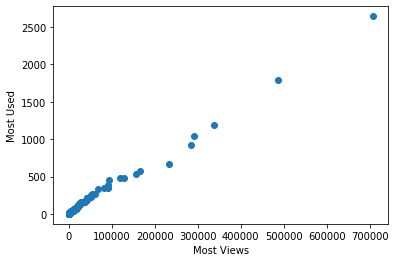

In [152]:
plt.scatter(most_viewed, most_used)
plt.xlabel("Most Views")
plt.ylabel("Most Used")
plt.show()

In [0]:
# creating a list of all tags:
all_tags = list(tag_count.keys())
#all_tags

In [154]:
correlation = pd.DataFrame(index=all_tags, columns = all_tags)
correlation["None"] = 0
correlation.loc["None"] = 0
correlation.fillna(0, inplace=True)

correlation.tail()

,machine-learning,image-recognition,natural-language-process,r,forecast,lstm,rnn,keras,object-detection,text,ocr,tensorflow,neural-network,deep-learning,classification,binary,gan,hyperparameter,generative-models,parameter,data,visualization,dimensionality-reduction,tsne,time-series,bigdata,python,reinforcement-learning,dqn,linear-regression,orange,evaluation,powerbi,cnn,accuracy,forecasting,data-mining,unsupervised-learning,java,gradient-descent,...,activity-recognition,doc2vec,dialog-flow,shap,definitions,hog,pathfinder,anonymization,non-convex,bayes-error,siamese,self-driving,state-of-the-art,mean-shift,fuzzy-classification,stemming,corpus,dump,wikipedia,data-transfer,paperspace,statsmodels,summarunner-architecture,version-control,map-reduce,proximal-svm,least-squares-svm,markov,bayesian-nonparametric,hurdle-model,marginal-effects,apache-nifi,huggingface,redshift,rmsle,rmse,manifold,libsvm,noisification,None
rmse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
manifold,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
libsvm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
noisification,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
for tags in df.Tags:
    correlation.loc[tags, tags] += 1

In [156]:
corr_most_used = correlation.loc[most_used.index, most_used.index]
corr_most_used.head()

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,cnn,nlp,time-series,lstm,pandas,regression,dataset,r,predictive-modeling,clustering,statistics,machine-learning-model,data-mining,image-classification,data,feature-selection,reinforcement-learning,data-science-model,pytorch,linear-regression,xgboost,feature-engineering,loss-function,data-cleaning,random-forest,logistic-regression,rnn,training,decision-trees,svm,cross-validation,multiclass-classification,...,history,spyder,multivariate-distribution,google-cloud,adaboost,refit-model,nn,c++,helmert-coding,james-stein-encoder,spearmans-rank-correlation,kendalls-tau-coefficient,rdkit,activation,counter-inference,data-indexing-techniques,nl2sql,lda-classifier,knime,cs231n,kitti-dataset,.net,3d-object-detection,impala,pgm,exploitation,cause-effect-relations,consumerweb,text-classification,parquet,pattern-recognition,gru,normal-equation,unseen-data,naive-bayes-algorithim,hashingvectorizer,frequentist,open-source,community,noisification
machine-learning,2642,495,415,360,193,254,104,185,124,111,126,66,62,117,99,63,121,61,89,138,95,68,54,87,47,88,25,65,62,71,35,41,50,55,38,44,55,53,40,30,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0
python,495,1785,160,135,276,98,163,230,62,70,103,59,241,59,53,24,35,45,35,37,26,23,35,25,17,41,41,29,29,19,14,37,25,30,16,9,22,22,23,23,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
deep-learning,415,160,1190,302,243,56,135,16,157,69,41,100,1,21,31,5,32,2,12,18,24,64,1,21,51,17,40,4,6,6,35,7,2,6,43,22,1,2,7,10,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
neural-network,360,135,302,1038,232,63,105,23,118,24,33,66,1,42,20,9,13,8,11,10,4,49,4,8,25,11,26,14,4,8,32,5,5,5,27,30,2,7,14,11,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
keras,193,276,243,232,919,56,252,33,116,23,49,128,3,31,12,10,11,0,3,16,1,45,1,3,8,7,11,7,3,3,43,5,0,0,23,14,1,2,13,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Enter Domain Knowledge
Domain knowledge can be very useful. Let's see how it can help us here.

You may have noticed that the most used tags are also the most viewed. From the top 10 tags of each, here's a list of the tags in common: `python, machine-learning, deep-learning, neural-network, keras, tensorflow, classification, scikit-learn`.

Do you know what each of these or most of these tags means? Could there be strong relations between them?

![Tags(https://datascience.stackexchange.com/tags)]
## strong relations:
we definitely see strong relations with `Machine-Learning` tags and all related libraries such as `scikit-learn`, `tensorflow`, `keras` and so on.

# Just a fad?
Before we officially make our recommendation, it would be nice to solidy our findings with additional proof. More specifically, one thing that comes to mind is "Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down? Back to SEDE!

The file `all_questions.csv` holds the result of the query below — this query fetches all of the questions ever asked on DSSE, their dates and tags.

```
SELECT Id, CreationDate, Tags

  FROM posts

 WHERE PostTypeId = 1;
```

In this we will track the interest in deep learning across time. We will:

- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of questions per time period.



### Read the file all_questions.csv into a dataframe.


In [0]:
all_questions = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

In [165]:
all_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22426 entries, 0 to 22425
Data columns (total 3 columns):
Id              22426 non-null int64
CreationDate    22426 non-null datetime64[ns]
Tags            22426 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 525.7+ KB


### Transform the tags column in a similar manner to what was previously done.


In [166]:
all_questions.Tags.value_counts()

<machine-learning>                                                                     332
<neural-network>                                                                       152
<r>                                                                                    138
<python><pandas>                                                                       137
<python>                                                                               110
                                                                                      ... 
<feature-selection><apache-spark><feature-extraction><feature-engineering><pyspark>      1
<clustering><scikit-learn>                                                               1
<keras><cnn><activation-function>                                                        1
<multiclass-classification><data-science-model>                                          1
<neural-network><keras><tensorflow><regression>                                          1

In [0]:
all_questions.Tags = all_questions.Tags.str.replace("^<|>$", "").str.split("><")


In [0]:
all_questions.Tags.fillna(0, inplace=True)

In [169]:
all_questions.Tags.head()

0                                         [clustering]
1                                         [nlp, tools]
2    [machine-learning, classification, bayesian-ne...
3                         [feature-selection, outlier]
4                                  [feature-selection]
Name: Tags, dtype: object

### Think about what questions should be classified as deep learning questions and the implement that definition.


In [0]:
# defining deeplearning as follows:

def define_deeplearining(x):
  deeplearning = ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]
  for tag in x:
    if tag in deeplearning:
      return 1
    else:
      return 0



In [0]:
all_questions["DeepLearning"] = all_questions.Tags.apply(define_deeplearining)

In [179]:
all_questions.DeepLearning.value_counts()

0    18514
1     3912
Name: DeepLearning, dtype: int64

In [180]:
all_questions.sample(5)

,Id,CreationDate,Tags,DeepLearning
13954,34026,2018-07-05 09:00:34,"[scikit-learn, decision-trees, feature-scaling...",1
169,54191,2019-06-21 04:16:26,"[python, time-series, pandas, lstm]",0
8543,16349,2017-01-16 17:36:42,"[machine-learning, r, predictive-modeling, ran...",0
15099,67724,2020-02-07 22:44:35,"[clustering, visualization, plotting]",0
3519,40998,2018-11-10 12:57:54,[python],0


### Decide on an adequate timeframe and track interest in deep learning across that timeframe:
- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of questions per time period;
### Write your observations and final recommendation in a markdown cell.


In [0]:
all_questions["CreationDate"] = pd.to_datetime(all_questions.CreationDate)

In [195]:
dl_per_dayofmonth = all_questions.groupby(all_questions.CreationDate.dt.day).sum()
dl_per_dayofweek = all_questions.groupby(all_questions.CreationDate.dt.dayofweek).sum()
dl_per_dayofweek

,Id,DeepLearning
CreationDate,,
0,135986883,628
1,137333890,628
2,146681021,662
3,143321604,644
4,128401766,577
5,81715565,367
6,89032645,406
